<a href="https://colab.research.google.com/github/kapko/Titanik_kaggle/blob/main/Titanik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

with open('cfg.json', 'r') as f:
    cfg = json.load(f)

X = pd.read_csv(cfg["data"]["train"])


In [2]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
X.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<Axes: xlabel='Pclass', ylabel='Survived'>

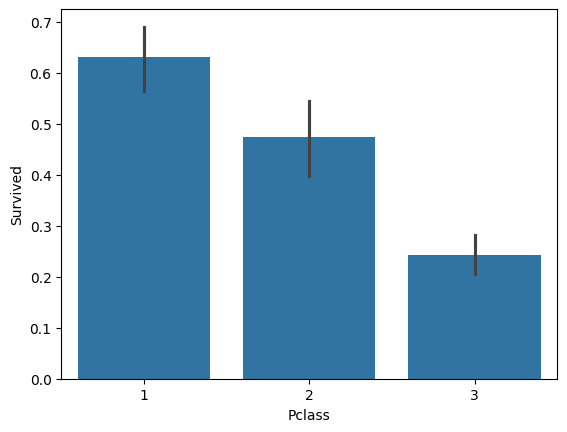

In [4]:
sns.barplot(X, x='Pclass', y='Survived')

<Axes: xlabel='Sex', ylabel='Survived'>

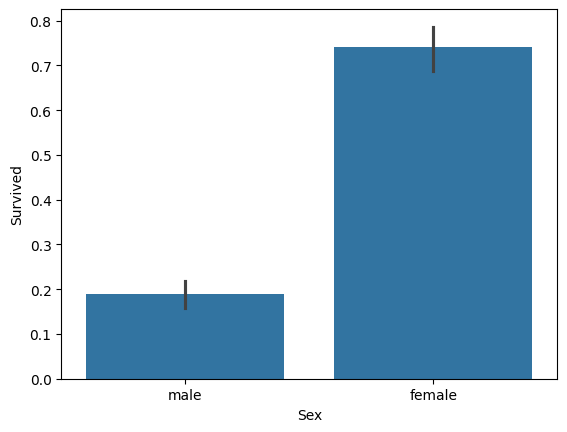

In [5]:
sns.barplot(X, x='Sex', y='Survived')

<Axes: >

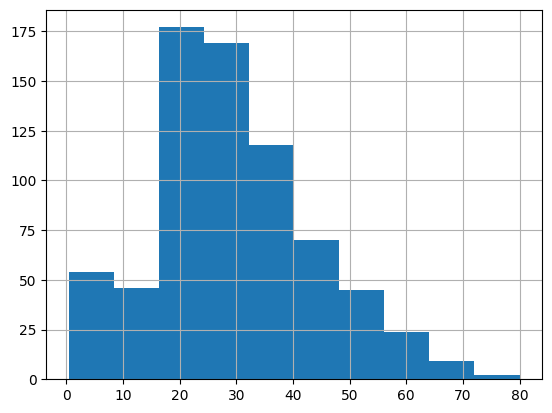

In [6]:
X.Age.hist()

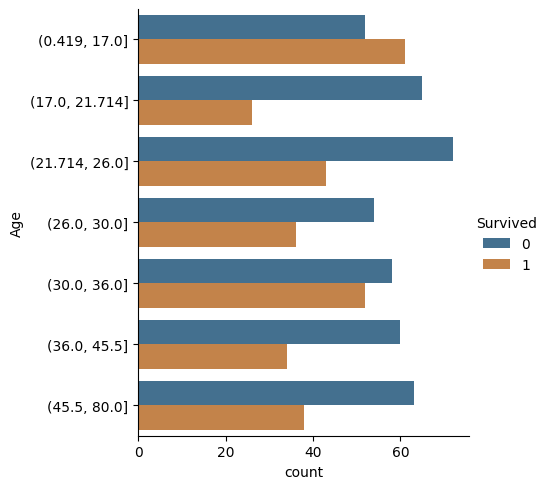

In [7]:
sns.catplot(data=X, y=pd.qcut(X.Age,7), hue='Survived', kind='count', saturation=0.5)

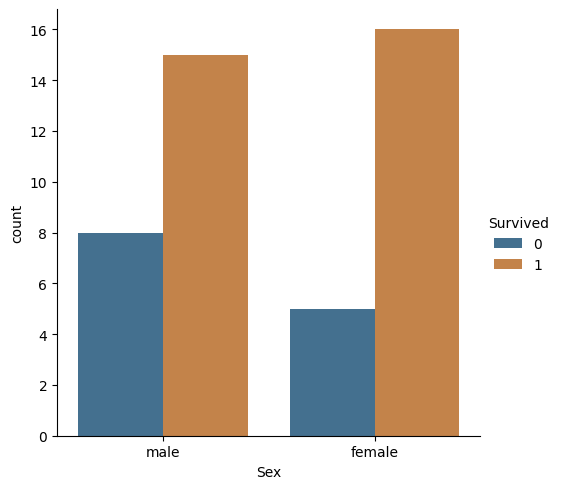

In [8]:
child= X[X.Age<6]
sns.catplot(data = child, hue='Survived',  x='Sex',kind='count', saturation=0.5)

In [9]:
def feat_engineering(X: pd.DataFrame) -> pd.DataFrame:
    X['Cabin_was_missing'] = X['Cabin'].isna().astype('int8')
    X['Deck'] = X['Cabin'].astype('string').str[0].fillna('U')

    most_common_embarked = X.Embarked.mode(dropna=True).iat[0]
    mean_age = X.Age.mean()

    X.Embarked = X.Embarked.fillna(most_common_embarked)
    X.Age = X.Age.fillna(mean_age)

    unique_decks = X['Deck'].unique()
    unique_decks = {deck: i for i, deck in enumerate(unique_decks)}
    X['Deck'] = X['Deck'].map(lambda x: unique_decks[x])

    # базовые бинарные/числовые
    X['Sex'] = X['Sex'].map({'male': 1, 'female': 0})
    X['Embarked'] = X['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
    X['FamilySize'] = (X['SibSp'] + X['Parch'] + 1).astype('int16')
    X['IsAlone'] = (X['FamilySize'] == 1).astype('int8')

    X.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'], inplace=True)
    return X

In [10]:
from sklearn.model_selection import train_test_split
Y = X['Survived'].astype(int) # get target
X.drop(columns=['Survived'], inplace=True)

In [11]:
# split data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42) 
len(X_train), len(X_val), len(y_train), len(y_val)

(712, 179, 712, 179)

In [12]:
X_train = feat_engineering(X_train)
X_val = feat_engineering(X_val)

In [13]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_was_missing,Deck,FamilySize,IsAlone
331,1,1,45.5,0,0,28.5000,2,0,0,1,1
733,2,1,23.0,0,0,13.0000,2,1,1,1,1
382,3,1,32.0,0,0,7.9250,2,1,1,1,1
704,3,1,26.0,1,0,7.8542,2,1,1,2,0
813,3,0,6.0,4,2,31.2750,2,1,1,7,0


In [14]:
X_val.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_was_missing,Deck,FamilySize,IsAlone
709,3,1,30.505845,1,1,15.2458,0,1,0,3,0
439,2,1,31.000000,0,0,10.5000,2,1,0,1,1
840,3,1,20.000000,0,0,7.9250,2,1,0,1,1
720,2,0,6.000000,0,1,33.0000,2,1,0,2,0
39,3,0,14.000000,1,0,11.2417,0,1,0,2,0


In [15]:
def corr_heatmap(X: pd.DataFrame):
    modes = ['spearman', 'kendall', 'pearson']

    for mode in modes:
        plt.figure(figsize=(8, 6))
        sns.heatmap(X.corr(method=mode), annot=True, cmap='RdYlGn')
        plt.title(f'Correlation Heatmap ({mode.capitalize()})') 
        plt.show()

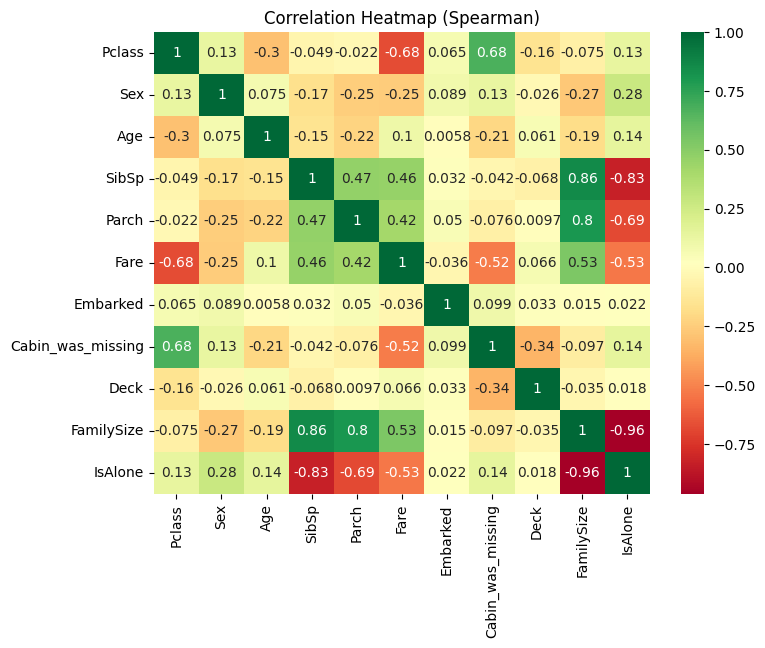

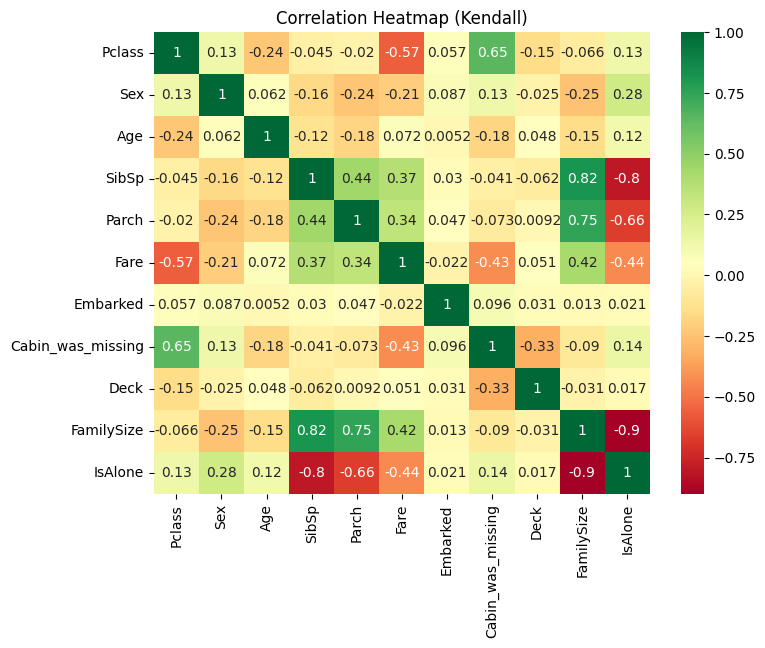

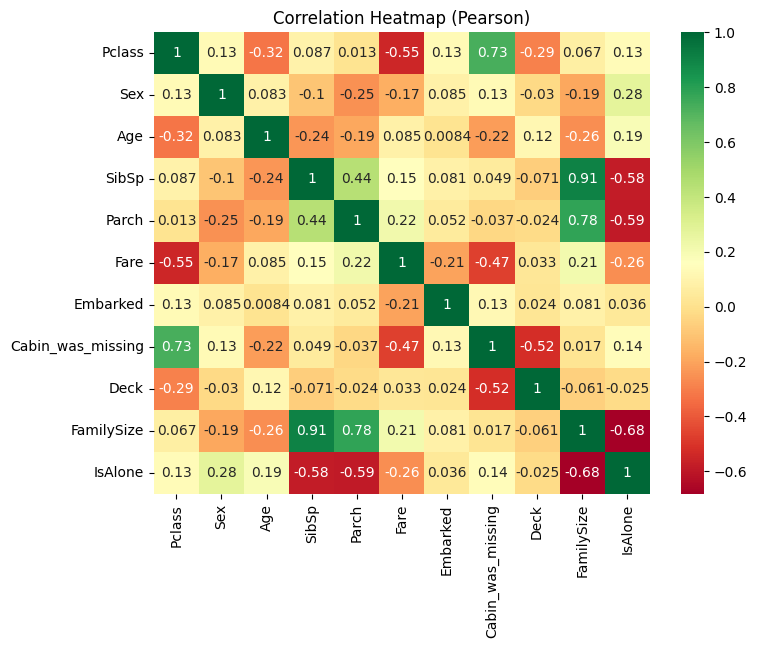

In [16]:
corr_heatmap(X_train)

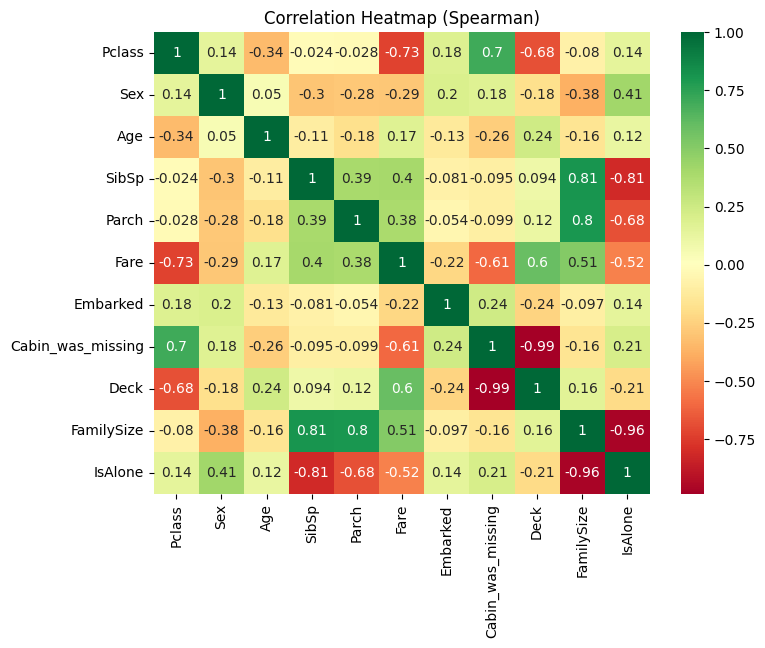

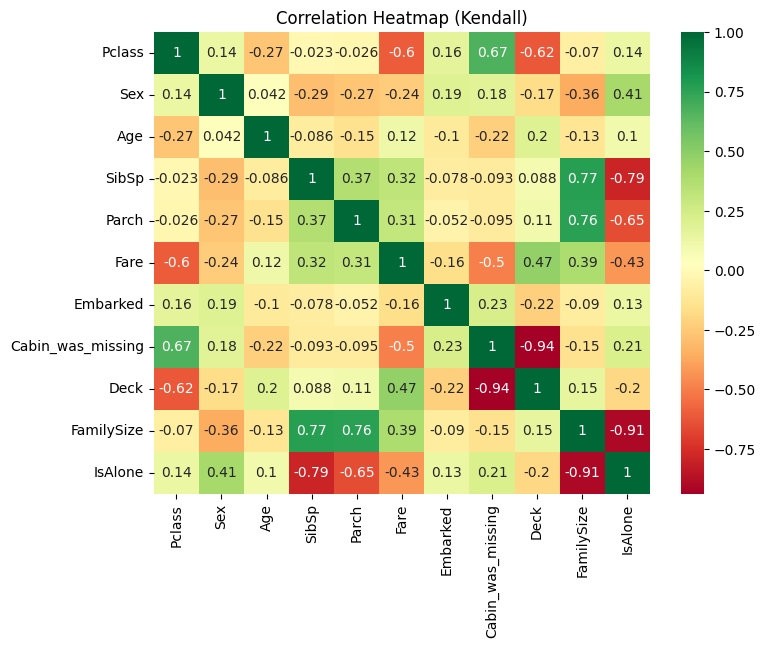

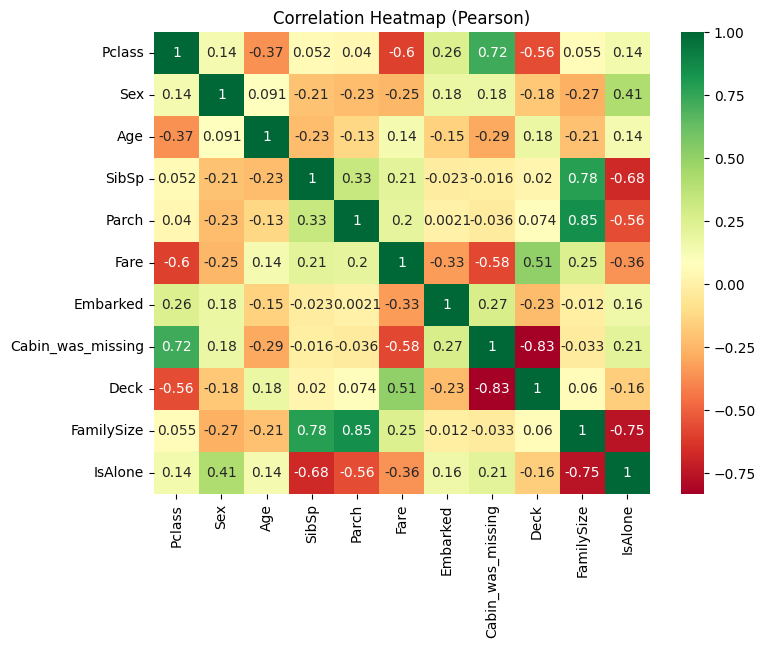

In [17]:
corr_heatmap(X_val)

In [18]:
X_train = X_train[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Cabin_was_missing', 'IsAlone', 'Deck']]
X_val = X_val[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Cabin_was_missing', 'IsAlone', 'Deck']]

## Train

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [20]:
models = {
    'LogReg': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'GradBoost': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier()
}

In [21]:
def train_model(X: pd.DataFrame, y: pd.Series, model: str):
    model.fit(X, y)
    pred = model.predict(X_val)

    acc = accuracy_score(y_val, pred)
    prec = precision_score(y_val, pred)
    rec = recall_score(y_val, pred)
    f1 = f1_score(y_val, pred)
    auc = roc_auc_score(y_val, pred)

    return acc, prec, rec, f1, auc


In [22]:
res = {}

for name, model in models.items():
    acc, prec, rec, f1, auc = train_model(X_train, y_train, model)
    res[name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'AUC': auc}

res_df = pd.DataFrame(res).T

c:\Users\Ian\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [23]:
res_df

,Accuracy,Precision,Recall,F1,AUC
LogReg,0.804469,0.774648,0.743243,0.758621,0.795431
DecisionTree,0.731844,0.654762,0.743243,0.696203,0.733526
RandomForest,0.810056,0.777778,0.756757,0.767123,0.802188
GradBoost,0.826816,0.820896,0.743243,0.780142,0.814479
XGBoost,0.782123,0.746479,0.716216,0.731034,0.772394
LightGBM,0.787709,0.757143,0.716216,0.736111,0.777156



=== LogReg ===
Accuracy:  0.8045
Precision: 0.7746
Recall:    0.7432
F1:        0.7586
ROC-AUC:   0.8795
PR-AUC(AP):0.8713
Confusion matrix:
        Pred0  Pred1
True0     89     16
True1     19     55

=== DecisionTree ===
Accuracy:  0.7263
Precision: 0.6712
Recall:    0.6622
F1:        0.6667
ROC-AUC:   0.7241
PR-AUC(AP):0.5883
Confusion matrix:
        Pred0  Pred1
True0     81     24
True1     25     49

=== RandomForest ===
Accuracy:  0.8101
Precision: 0.7778
Recall:    0.7568
F1:        0.7671
ROC-AUC:   0.8792
PR-AUC(AP):0.8345
Confusion matrix:
        Pred0  Pred1
True0     89     16
True1     18     56


c:\Users\Ian\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== GradBoost ===
Accuracy:  0.8268
Precision: 0.8209
Recall:    0.7432
F1:        0.7801
ROC-AUC:   0.8797
PR-AUC(AP):0.8610
Confusion matrix:
        Pred0  Pred1
True0     93     12
True1     19     55

=== XGBoost ===
Accuracy:  0.7821
Precision: 0.7465
Recall:    0.7162
F1:        0.7310
ROC-AUC:   0.8654
PR-AUC(AP):0.8416
Confusion matrix:
        Pred0  Pred1
True0     87     18
True1     21     53
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits w

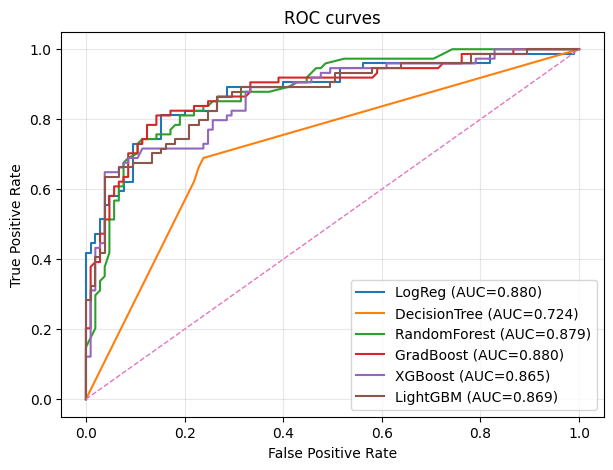

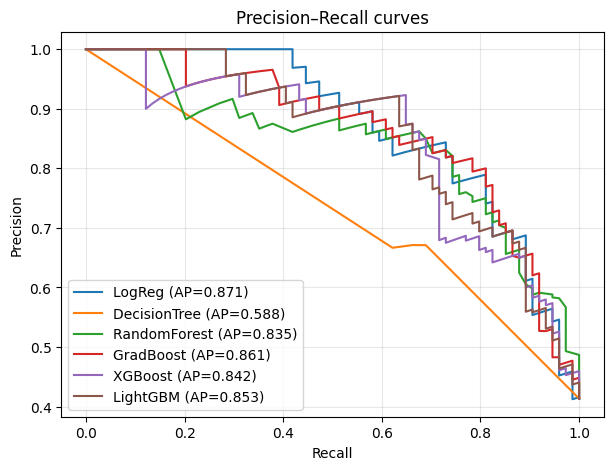

In [24]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)

results = []
roc_curves = {}
pr_curves  = {}

for name, model in models.items():
    if name == "LogReg":
        model.fit(X_train, y_train)
        proba = model.predict_proba(X_val)[:, 1]
        pred  = (proba >= 0.5).astype(int)
    else:
        model.fit(X_train, y_train)
        proba = model.predict_proba(X_val)[:, 1]
        pred  = model.predict(X_val)

    acc  = accuracy_score(y_val, pred)
    prec = precision_score(y_val, pred, zero_division=0)
    rec  = recall_score(y_val, pred, zero_division=0)
    f1   = f1_score(y_val, pred, zero_division=0)
    auc  = roc_auc_score(y_val, proba)
    ap   = average_precision_score(y_val, proba)

    cm = confusion_matrix(y_val, pred)
    results.append([name, acc, prec, rec, f1, auc, ap])
    print(f"\n=== {name} ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1:        {f1:.4f}")
    print(f"ROC-AUC:   {auc:.4f}")
    print(f"PR-AUC(AP):{ap:.4f}")
    print("Confusion matrix:\n", pd.DataFrame(cm, index=['True0','True1'], columns=['Pred0','Pred1']))

    fpr, tpr, _ = roc_curve(y_val, proba)
    roc_curves[name] = (fpr, tpr, auc)

    precisions, recalls, _ = precision_recall_curve(y_val, proba)
    pr_curves[name] = (precisions, recalls, ap)

res_df = pd.DataFrame(results, columns=['Model','Accuracy','Precision','Recall','F1','ROC_AUC','PR_AUC(AP)'])
print("\n\nSummary metrics:\n", res_df.sort_values('Accuracy', ascending=False))

plt.figure(figsize=(7,5))
for name, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(7,5))
for name, (precisions, recalls, ap) in pr_curves.items():
    plt.plot(recalls, precisions, label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curves")
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.show()
